In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
data = pd.read_csv('data/Hitters.csv').dropna()
data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [3]:
df = pd.get_dummies(data, columns=['League', 'Division', 'NewLeague'], drop_first=True).reset_index(drop=True)
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
3,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3,700.0,1,0,1
259,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20,875.0,0,0,0
260,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7,385.0,0,1,0
261,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12,960.0,0,0,0


In [4]:
# Create X, X_scaled, y
X = df.drop(columns='Salary')
X_scaled = pd.DataFrame(scale(X))
y = df['Salary']

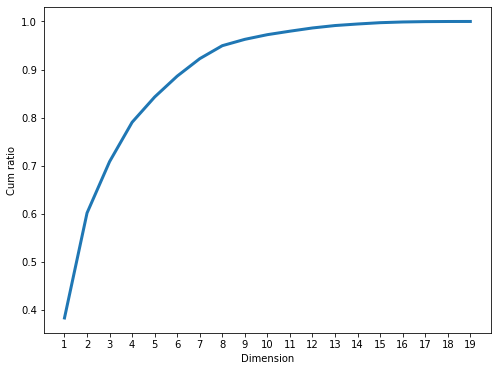

In [5]:
# Create PCA and transform to all principal components
pca = PCA()
P = pd.DataFrame(pca.fit_transform(X_scaled))

# Create a table to see how explained variance ratio change due to incease number of components
dimension_variance_explained = pd.DataFrame({'Dimension': np.arange(1,pca.n_components_ + 1),'Cum ratio': np.cumsum(pca.explained_variance_ratio_)})

# Draw variance explained by PCA
plt.figure(figsize=(8,6))
sb.lineplot(data=dimension_variance_explained, x='Dimension', y='Cum ratio', linewidth=3)
plt.xticks(dimension_variance_explained['Dimension'])
plt.show()

In [11]:
def display_mse(mse_result, good_point):
    plt.figure(figsize=(8,6))
    # Plot MSE line
    plt.plot(mse_result.index, mse_result, label='MSE')

    # Plot Min point
    plt.scatter(mse_result.argmin()+1, mse_result.min(), label='Min MSE: {:,.0f} at {} principal components'.format(mse_result.min(), mse_result.argmin()+1))

    # Plot Reasonable point
    if good_point != mse_result.argmin()+1:
        plt.scatter(good_point, mse_result[good_point], label='Good MSE: {:,.0f} at {} principal components'.format(mse_result[good_point], good_point))

    plt.xlabel('Number Principal Components')
    plt.ylabel('Mean Squared Error')
    plt.xticks(mse_result.index)
    plt.legend()

## Principal Component Regression - PCR

In [8]:
# Method 1: Create mse_PCR using manual way, step by step
mse_PCR_1 = pd.Series([])

# Proccess Linear regression for each n principal components
for i in range(1,len(X.columns)+1):
    
    # Create pca with i components
    pca = PCA(n_components=i)
    P_current = pd.DataFrame(pca.fit_transform(X_scaled))

    # Create train-test on K-folds method, train data on principal components
    cv = KFold(n_splits=10, random_state=None, shuffle=False).split(P_current)
    
    mse = []

    for train, test in cv:
        
        # Create train-test set and add constant to P
        P_train, y_train = sm.add_constant(P_current.iloc[train]), y.iloc[train]
        P_test, y_test   = sm.add_constant(P_current.iloc[test]), y.iloc[test]

        # Fit model
        lm = sm.OLS(y_train, P_train).fit()

        # Calculate mse
        y_pred = lm.predict(P_test)
        mse.append(mean_squared_error(y_test, y_pred))

    # Add result to mse mean
    mse_PCR_1.loc[i] = np.mean(mse)

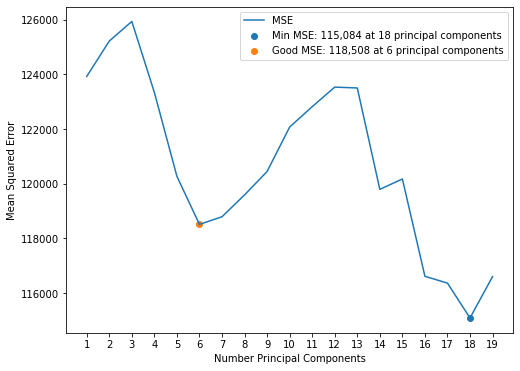

In [13]:
display_mse(mse_PCR_1, 6)

In [19]:
# Method 2: Create mse_PCR using cross_val_score
mse_PCR_2 = pd.Series([])

# Proccess Linear regression for each n principal components
for i in range(1,len(X.columns)+1):
    
    # Create pca with i components
    pca = PCA(n_components=i)
    P_current = pd.DataFrame(pca.fit_transform(X_scaled))

    # Create train-test on K-folds method, train data on principal components
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    
    # Create Linear OLS func
    lm = LinearRegression()
    
    # Short way to create mse array of all 10-Folds is using cross_val_score
    score = cross_val_score(lm, P_current, y, cv=cv, scoring='neg_mean_squared_error')

    # Add result to mse mean
    mse_PCR_2.loc[i] = np.mean(np.abs(score))

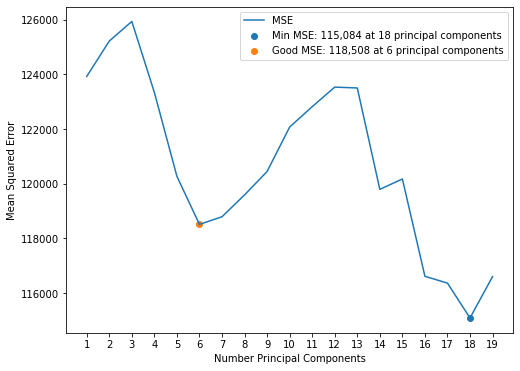

In [20]:
display_mse(mse_PCR_2, 6)

In [21]:
# Both method have same result, second is shorter, but understand the way first one do, we can understand it all clearly
# Result show that min MSE have 115k at 18 principal component for regression, not better than Lasso and Ridge
# Good point can be at 6 PCs

## Partial Least Squared - PLS

In [23]:
# Method 1: Do PLS step by step, manually
mse_PLS_1 = pd.Series([])

# Proccess PLS for each n components
for i in range(1, len(X.columns)+1):

    # Create PLS function
    pls = PLSRegression(n_components=i)

    mse = []

    # Create train-test on K-folds method, train data on principal components
    cv = KFold(n_splits=10, random_state=None, shuffle=False).split(X_scaled)

    for train, test in cv:

        # Create train, test fuction
        X_train, y_train = X_scaled.iloc[train], y.iloc[train]
        X_test, y_test   = X_scaled.iloc[test], y.iloc[test]

        # Fit model
        pls.fit(X_train, y_train)

        # Calculate mse
        y_pred = pls.predict(X_test)
        mse.append(mean_squared_error(y_test, y_pred))

    # Add result to mse mean
    mse_PLS_1.loc[i] = np.mean(mse)

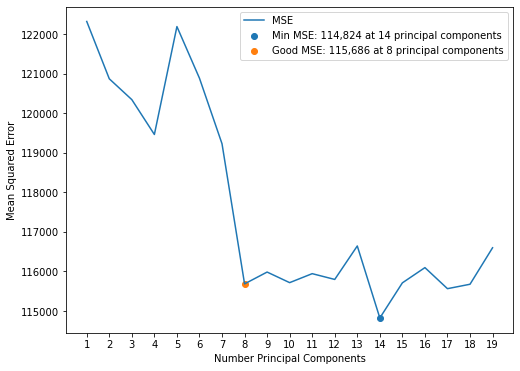

In [24]:
display_mse(mse_PLS_1, 8)

In [25]:
# Method 2: Create mse_PLS using cross_val_score
mse_PLS_2 = pd.Series([])

# Proccess PLS for each n components
for i in range(1,len(X.columns)+1):
    
    # Create PLS function
    pls = PLSRegression(n_components=i)

    # Create train-test on K-folds method, train data on principal components
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    
    # Short way to create mse array of all 10-Folds is using cross_val_score
    score = cross_val_score(pls, X_scaled, y, cv=cv, scoring='neg_mean_squared_error')

    # Add result to mse mean
    mse_PLS_2.loc[i] = np.mean(np.abs(score))

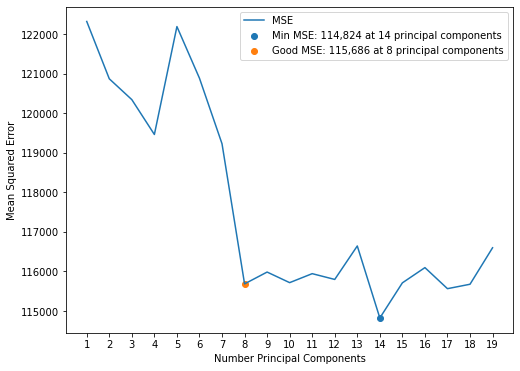

In [26]:
display_mse(mse_PLS_2, 8)

In [28]:
# Both method bring same results, second one is shorter
# PLS still like PCR, not better than Lasso or Ridge, but result improved PCR method